# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).

**Heavily edited by blackle mori. click on the link above for the original paper and colab notebook**


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 omega=30):
        super().__init__()
        self.omega = omega
        self.hidden_layers = hidden_layers
        self.hidden_features = hidden_features
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=omega))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=omega))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / omega, 
                                              np.sqrt(6 / hidden_features) / omega)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=omega))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [4]:
from skimage import io
def get_image_tensor(sidelength, filename):
    img = Image.fromarray(skimage.io.imread(filename, as_gray=True))        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, filename):
        super().__init__()
        img = get_image_tensor(sidelength, filename)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [68]:
cat = ImageFitting(362, "chess.png")
catloader = DataLoader(cat, batch_size=1, pin_memory=True, num_workers=0)
catfocus = ImageFitting(256, "bloom_weights.png")
focusloader = DataLoader(catfocus, batch_size=1, pin_memory=True, num_workers=0)
catcolor = ImageFitting(256, "catcolor.jpg")
colorloader = DataLoader(catcolor, batch_size=1, pin_memory=True, num_workers=0)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [75]:
import copy

def train_siren(dataloader, hidden_features, hidden_layers, omega, epochs):
  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
  _, focus = next(iter(focusloader))
  focus = focus.cuda()

  img_curr = Siren(in_features=2, out_features=1, hidden_features=hidden_features, 
                   hidden_layers=hidden_layers, outermost_linear=True, omega=omega)
  img_curr.cuda()
  optim = torch.optim.Adam(lr=1e-4, params=img_curr.parameters())

  total_steps = 10000
  update = int(total_steps/10)
  for step in range(total_steps):
    model_output, coords = img_curr(model_input)
    loss = (model_output - ground_truth)**2
    #loss = (focus*.4+.6).mul(loss)
    loss = loss.mean()
        
    if (step % update) == update-1:
      print("Step %d, Current loss %0.6f" % (step, loss))
      fig, axes = plt.subplots(1,2, figsize=(18,6))
      axes[0].imshow(model_output.cpu().view(362,362).detach().numpy(), cmap='gray', vmin=-1, vmax=1)
      axes[1].imshow((model_output - ground_truth).cpu().view(362,362).detach().numpy(), cmap='gray', vmin=-1, vmax=1)
      plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()
    
  return img_curr

First we train the black and white version of the cat

Step 999, Current loss 0.004953


Step 1999, Current loss 0.002088


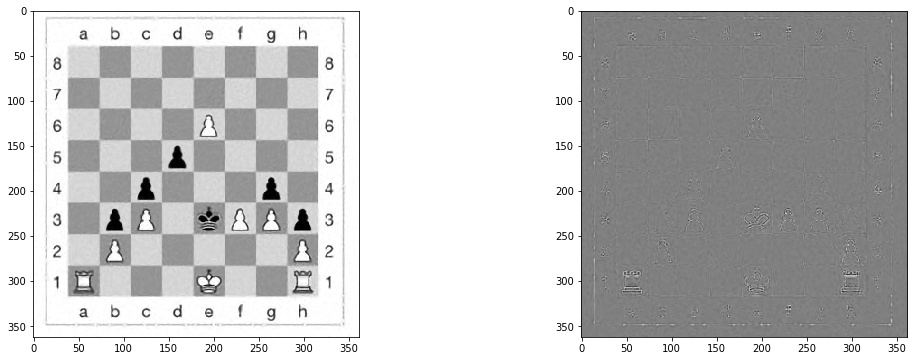

Step 2999, Current loss 0.001250


Step 3999, Current loss 0.000951


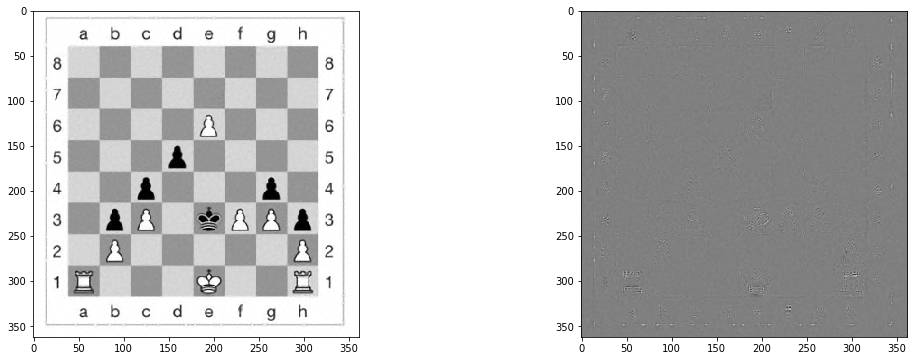

Step 4999, Current loss 0.000780


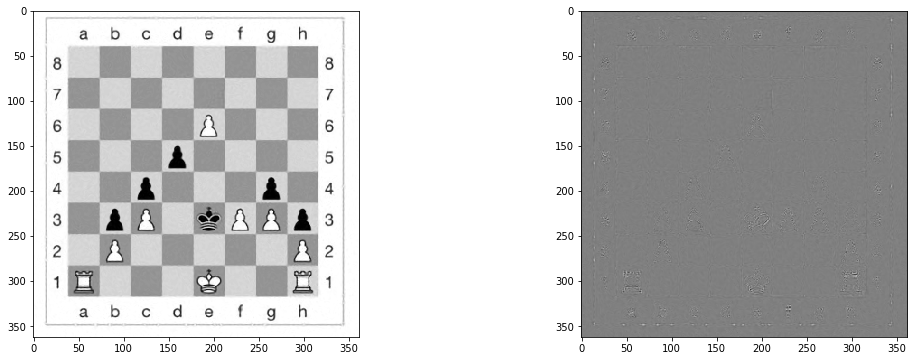

Step 5999, Current loss 0.000670


Step 6999, Current loss 0.000566


Step 7999, Current loss 0.000524


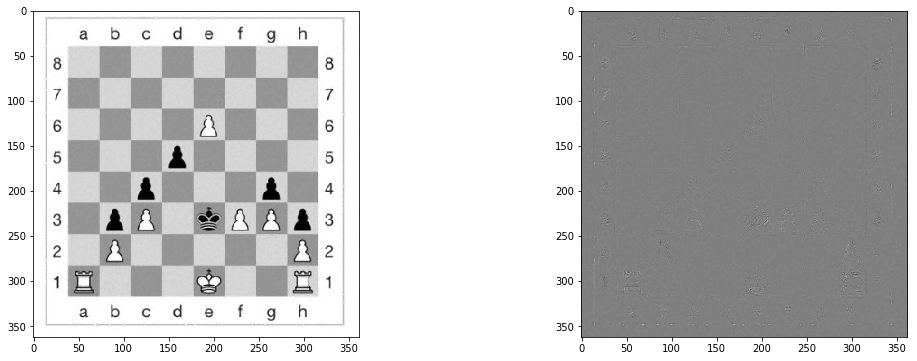

Step 8999, Current loss 0.000415


Step 9999, Current loss 0.000408


vec4 k0_0=sin(uv.x*vec4(-5.37,-2.91,11.6,11.9)+uv.y*vec4(8.68,3.85,-2.63,4.46)+vec4(10.5,-13.6,19.3,-6.22));
vec4 k0_1=sin(uv.x*vec4(-5.4,-13.9,7.05,-4.09)+uv.y*vec4(13,5.6,13.8,-.611)+vec4(18.9,-20.9,16.9,-17.5));
vec4 k0_2=sin(uv.x*vec4(-13.8,6.55,-5.13,.887)+uv.y*vec4(6.71,12.8,-11.2,-12.3)+vec4(2.86,-11.4,6.2,-7.35));
vec4 k0_3=sin(uv.x*vec4(-10.8,-13.9,5.64,7.52)+uv.y*vec4(7.3,-3.19,7.69,-2.9)+vec4(-.992,-3.78,17,4.55));
vec4 k0_4=sin(uv.x*vec4(11,-8.3,-4.49,-7.2)+uv.y*vec4(-6.84,7.21,-3.16,5.1)+vec4(-.598,-3.55,-1.46,7.43));
vec4 k0_5=sin(uv.x*vec4(3.27,-12,5.91,10.2)+uv.y*vec4(13.3,5.39,-9.43,10.4)+vec4(-17.2,8.57,3.29,17.7));
vec4 k0_6=sin(uv.x*vec4(3.74,-7.46,8.87,10.8)+uv.y*vec4(-1.71,-7.16,-1.18,-5.38)+vec4(-2.2,-14.5,-.908,10.6));
vec4 k0_7=sin(uv.x*vec4(6.05,-12.9,5.49,1.34)+uv.y*vec4(6.53,-14.4,9.92,6.2)+vec4(4.29,14.7,-2.36,-16.2));
vec4 k0_8=sin(uv.x*vec4(3.94,-9.21,9.01,2.84)+uv.y*vec4(-3.15,-7.86,15.1,.943)+vec4(-6.97,9.19,12.3,12.6));
vec4 k0_9=sin(uv.x*vec4(2.07,-14

In [83]:
for i in range(1):
    cat_siren = train_siren(catloader, 64, 4, 30, 500)
    serialize_to_shadertoy(cat_siren, "k")


And then we train a colour map for the cat (this will be passed into a colour gradient)

In [ ]:
color_siren = train_siren(colorloader, 4, 2, 8, 500)

In [84]:
import re

def dump_data(dat):
  dat = dat.cpu().detach().numpy()
  return dat

def print_vec4(ws):
  vec = "vec4(" + ",".join(["{0:.4g}".format(w) for w in ws]) + ")"
  vec = re.sub(r"\b0\.", ".", vec)
  return vec

def print_mat4(ws):
  mat = "mat4(" + ",".join(["{0:.4g}".format(w) for w in np.transpose(ws).flatten()]) + ")"
  mat = re.sub(r"\b0\.", ".", mat)
  return mat

def serialize_to_shadertoy(siren, varname):
  #first layer
  omega = siren.omega
  chunks = int(siren.hidden_features/4)
  in_w = dump_data(siren.net[0].linear.weight)
  in_bias = dump_data(siren.net[0].linear.bias)
  for row in range(chunks):
    x_vec = in_w[row*4:(row+1)*4,1]*omega
    y_vec = in_w[row*4:(row+1)*4,0]*-1*omega
    bias = in_bias[row*4:(row+1)*4]*omega
    print(("vec4 %s0_%d=sin(uv.x*" % (varname, row)) +print_vec4(x_vec) + "+uv.y*" + print_vec4(y_vec) + "+" + print_vec4(bias)+");")

  #hidden layers
  for layer in range(siren.hidden_layers):
    layer_w = dump_data(siren.net[layer+1].linear.weight)
    layer_bias = dump_data(siren.net[layer+1].linear.bias)
    for row in range(chunks):
      line = ("vec4 %s%d_%d" % (varname, layer+1, row)) + "=sin("
      for col in range(chunks):
        mat = layer_w[row*4:(row+1)*4,col*4:(col+1)*4]*omega
        line += print_mat4(mat) + ("*%s%d_%d"%(varname, layer, col)) + "+\n    "
      bias = layer_bias[row*4:(row+1)*4]*omega
      line += print_vec4(bias)+");"
      print(line)

  #output layer
  out_w = dump_data(siren.net[-1].weight)
  out_bias = dump_data(siren.net[-1].bias)
  line = "float %s=" % varname
  for row in range(chunks):
    vec = out_w[0,row*4:(row+1)*4]
    line += ("dot(%s%d_%d,"%(varname, siren.hidden_layers, row)) + print_vec4(vec*.5) + ")+\n    "
  print(line + "{:0.3f}".format(out_bias[0]*.5+.5)+";")

  #for param in siren.parameters():
  #  print(param.data)

print("//luma network")
serialize_to_shadertoy(cat_siren, "f")
print("//color network")
serialize_to_shadertoy(color_siren, "c")

//luma network
vec4 f0_0=sin(uv.x*vec4(-5.372,-2.909,11.59,11.92)+uv.y*vec4(8.681,3.853,-2.631,4.465)+vec4(10.49,-13.61,19.34,-6.217));
vec4 f0_1=sin(uv.x*vec4(-5.401,-13.94,7.05,-4.094)+uv.y*vec4(13.01,5.604,13.84,-.6109)+vec4(18.9,-20.89,16.94,-17.47));
vec4 f0_2=sin(uv.x*vec4(-13.8,6.55,-5.128,.8872)+uv.y*vec4(6.713,12.78,-11.16,-12.27)+vec4(2.856,-11.38,6.202,-7.355));
vec4 f0_3=sin(uv.x*vec4(-10.76,-13.93,5.64,7.519)+uv.y*vec4(7.302,-3.185,7.693,-2.898)+vec4(-.992,-3.78,16.97,4.55));
vec4 f0_4=sin(uv.x*vec4(11.02,-8.303,-4.486,-7.201)+uv.y*vec4(-6.841,7.205,-3.162,5.099)+vec4(-.5982,-3.548,-1.46,7.432));
vec4 f0_5=sin(uv.x*vec4(3.271,-11.98,5.911,10.25)+uv.y*vec4(13.25,5.393,-9.427,10.43)+vec4(-17.25,8.573,3.294,17.65));
vec4 f0_6=sin(uv.x*vec4(3.743,-7.458,8.868,10.75)+uv.y*vec4(-1.715,-7.158,-1.18,-5.376)+vec4(-2.198,-14.51,-.9075,10.58));
vec4 f0_7=sin(uv.x*vec4(6.049,-12.89,5.489,1.344)+uv.y*vec4(6.531,-14.39,9.922,6.199)+vec4(4.295,14.67,-2.364,-16.2));
vec4 f0_8=sin(uv.x*vec

NameError: name 'color_siren' is not defined

In [ ]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(1024, 2)
    model_out, _ = cat_siren(out_of_range_coords.cuda())
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(model_out.cpu().view(1024,1024).numpy(), cmap='gray', vmin=-1, vmax=1)
    plt.show()